In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import funcionalidade as fc

In [2]:
ativos = pd.read_pickle('ativos_fatura_premiada.pkl')

In [3]:
cliques = pd.read_csv('export_retornos_infobip_fatura_turbinada.csv', usecols = ['to','send_at','opens','clicks'], parse_dates=['send_at'])

In [4]:
cliques.head()

,to,send_at,opens,clicks
0,leandrobarbosaa528@gmail.com,2023-03-23 10:45:54,NaN,NaN
1,gabriellareis.comercial@gmail.com,2023-03-23 10:45:22,NaN,NaN
2,hian.100@hotmail.com,2023-03-23 10:45:42,NaN,NaN
3,samag967@gmail.com,2023-03-17 12:38:38,NaN,NaN
4,jefersomnunes39@gmail.com,2023-03-23 10:50:40,NaN,NaN


In [5]:
len(cliques)

5391143

In [6]:
cliques['opens'].sum()

1024282.0

In [7]:
cliques['clicks'].sum()

80135.0

In [8]:
cliques['opens'] = cliques['opens'].fillna(0.0)
cliques['clicks'] = cliques['clicks'].fillna(0.0)

In [9]:
cliques = cliques.groupby('to').agg({'opens':['max'],'clicks':['max'],'send_at':['min', 'max'] })
cliques.columns = cliques.columns.droplevel(0)
cliques = cliques.reset_index()
cliques.head()

,to,max,max,min,max
0,0.9martinsmariana@gmail.com,1.0,0.0,2023-03-17 13:02:41,2023-03-30 14:24:44
1,0.9pollyane9798@gmail.com,0.0,0.0,2023-03-17 12:53:47,2023-03-30 14:21:39
2,0.notbook.0@gmail.com,1.0,0.0,2023-03-17 13:02:51,2023-03-30 14:24:48
3,00.willian@gmail.com,0.0,0.0,2023-03-17 12:53:37,2023-03-30 14:21:26
4,000.azmildo@gmail.com,0.0,0.0,2023-03-17 13:02:55,2023-03-30 14:24:40


In [10]:
cliques.columns = ['to', 'opens', 'clicks', 'send_at_min', 'send_at_max']
cliques.head()

,to,opens,clicks,send_at_min,send_at_max
0,0.9martinsmariana@gmail.com,1.0,0.0,2023-03-17 13:02:41,2023-03-30 14:24:44
1,0.9pollyane9798@gmail.com,0.0,0.0,2023-03-17 12:53:47,2023-03-30 14:21:39
2,0.notbook.0@gmail.com,1.0,0.0,2023-03-17 13:02:51,2023-03-30 14:24:48
3,00.willian@gmail.com,0.0,0.0,2023-03-17 12:53:37,2023-03-30 14:21:26
4,000.azmildo@gmail.com,0.0,0.0,2023-03-17 13:02:55,2023-03-30 14:24:40


In [11]:
#ativos.to_csv('ativos_fatura_premiada.csv')

In [12]:
ativos['grupo_comunicacao'].value_counts()

Comunicação MCC         1404826
Sem comunicação          173079
Comunicação Genérica     150575
Name: grupo_comunicacao, dtype: int64

## ATIVOS - Análise comunicação genérica x MCC

In [13]:
ativos_v1 = ativos.query('grupo_comunicacao != "Sem comunicação"')
ativos_v1['grupo'] = ['alvo' if x == 'Comunicação MCC' else 'controle' for x in ativos_v1['grupo_comunicacao']]

/tmp/ipykernel_503857/1857667637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ativos_v1['grupo'] = ['alvo' if x == 'Comunicação MCC' else 'controle' for x in ativos_v1['grupo_comunicacao']]


### Trazendo conversão

In [14]:
ativos_v1_c = fc.traz_conversao('flavia-costa', '2023-03-17', '2023-03-24', 'cpf', ativos_v1)

In [15]:
len(ativos_v1_c)

1555401

In [23]:
ativos_v1_c['converteu'].value_counts()

0.0    796281
1.0    759120
Name: converteu, dtype: int64

### Traz personas

In [16]:
import acessos as ac

In [17]:
personas = ac.df_athena_q('flavia-costa', 
                          """select 
                                ci.cpf
                                , max(email) as to
                                , max(ds_cluster_sociodemographic) as ds_cluster_sociodemographic
                                from customer_curated_zone.ca_book_cliente_cluster cl
                                left join customer_curated_zone.ca_book_cliente ci on (ci.id_customer = cl.id_customer)
                                left join growth_curated_zone.clientes gc on (gc.cpf = ci.cpf)
                                group by 1 """)

ativos_v1_p1 = ativos_v1_c.join(personas.set_index('cpf'), how = 'left', on = 'cpf')

In [18]:
ativos_v1_p = ativos_v1_p1.join(cliques.set_index('to'), how = 'left', on = 'to')

In [19]:
limite_disp = ac.df_athena_q('flavia-costa', 
                          """with base_limite_diaria as (
                                    select
                                    dt_data
                                    , cpf
                                    , limite
                                    , (limite - utilizado) as limite_disponivel
                                    , iu
                                    from credit_curated_zone.credit_iu_will
                                    where dt_data < to_date('2023-03-17','yyyy-mm-dd')
                                    union all
                                    select
                                    dt_movimentacao as dt_data 
                                    , cpf 
                                    , limite
                                    , limite_disponivel
                                    , iu
                                    from credit_curated_zone.credit_iu_pag
                                    where dt_movimentacao < to_date('2023-03-17','yyyy-mm-dd')
                                    )
                                    , base_lim_rankeada as (
                                    select *
                                    , row_number() over (partition by cpf order by cpf asc, dt_data desc, iu desc) as linha
                                    from base_limite_diaria
                                    )
                                    select 
                                    cpf
                                    , max(limite) as limite
                                    , min(limite_disponivel) as limite_disponivel
                                    , max(iu) as iu
                                    from base_lim_rankeada
                                    where linha = 1
                                    group by 1 """)

ativos_v1_p = ativos_v1_p.join(limite_disp.set_index('cpf'), how = 'left', on = 'cpf')

In [20]:
ativos_v1_p['opens'] = ativos_v1_p['opens'].fillna(0.0)
ativos_v1_p['clicks'] = ativos_v1_p['clicks'].fillna(0.0)
ativos_v1_p = ativos_v1_p.replace([np.inf, -np.inf], 0)

### Análises de Lift

In [104]:
#ativos_v1_p.to_pickle('ativos_v1_conversao.pkl')

In [105]:
ativos_v1_p = pd.read_pickle('ativos_v1_conversao.pkl')

In [106]:
ativos_v1_p.head()

,cpf,grupo_comunicacao,segmento_mcc_agg,nr_score_ie,yearmonth_ie,status,safra,grupo,conta_cartao,converteu,...,clicks,send_at_min,send_at_max,limite,limite_disponivel,iu,fx_limite,fx_iu,fx_limite_disp,cluster_persona
0,91908973234,Comunicação MCC,1 - SUPERMERCADO,29.713168,202302.0,Ativo,2021-09-01,alvo,NaN,0.0,...,0.0,NaT,NaT,500.0,495.00,0.01,2,1,5,26
1,14258158470,Comunicação MCC,1 - SUPERMERCADO,50.899609,202302.0,Ativo,2021-10-01,alvo,NaN,0.0,...,0.0,2023-03-17 12:38:51,2023-03-30 14:26:19,200.0,105.10,0.47,1,6,3,10
2,22377212468,Comunicação MCC,1 - SUPERMERCADO,59.104737,202302.0,Ativo,2022-02-01,alvo,NaN,0.0,...,0.0,2023-03-17 12:38:40,2023-03-30 14:26:20,200.0,7.50,0.96,1,9,2,23
3,16004179493,Comunicação MCC,1 - SUPERMERCADO,56.762277,202302.0,Ativo,2022-08-01,alvo,NaN,0.0,...,0.0,2023-03-17 12:38:41,2023-03-30 14:26:14,500.0,252.32,0.50,2,6,4,10
4,08374986514,Comunicação MCC,1 - SUPERMERCADO,68.413733,202302.0,Ativo,2022-06-01,alvo,NaN,1.0,...,0.0,NaT,NaT,500.0,-8.04,1.02,2,10,1,15


Análise reduzida geral

In [28]:
fc.testes_iterativos(ativos_v1_p.query('opens == 1'))

           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      358383  0.495224  325.666699  57799325.65   3.442337  610946.0
controle   40436  0.499901  319.103173   6450351.53   3.443307   69603.0
_____________________
Lift da conversão: -0.94%
Estatística t do teste de diferença de proporções: -1.78
P-valor do teste de diferença de proporções: 0.074584
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 2.06%
Estatística t do teste de spending: 0.77
P-valor do teste de spending: 0.440232
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -0.03%
Estatística t do teste de frequencia: -1.08
P-valor do teste de frequencia: 0.280218
A diferença de frequênc

In [29]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1'))

           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      193433  0.563622  328.832088  35850260.74   3.710850  404568.0
controle   23333  0.565594  328.455710   4334630.01   3.702281   48859.0
_____________________
Lift da conversão: -0.35%
Estatística t do teste de diferença de proporções: -0.57
P-valor do teste de diferença de proporções: 0.56605
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 0.11%
Estatística t do teste de spending: -0.15
P-valor do teste de spending: 0.884438
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 0.23%
Estatística t do teste de frequencia: -0.11
P-valor do teste de frequencia: 0.911539
A diferença de frequênci

Análise por recortes

In [30]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52').query('opens == 1'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      12752  0.481728  285.339937  1752843.23   2.817190  17306.0
controle   1570  0.452229  273.579958   194241.77   2.690141   1910.0
_____________________
Lift da conversão: 6.52%
Estatística t do teste de diferença de proporções: 2.21
P-valor do teste de diferença de proporções: 0.027252
Conclusão:
A diferença de conversão é estatisticamente significativa
______________________________________________________________
Lift do spending: 4.3%
Estatística t do teste de spending: 1.45
P-valor do teste de spending: 0.147745
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 4.72%
Estatística t do teste de frequencia: 2.31
P-valor do teste de frequencia: 0.020704
A diferença de frequência é es

In [63]:
ativos_v1_p['cluster_persona'] = ativos_v1_p['ds_cluster_sociodemographic'].str[0:2]
#ativos_v1_p['cluster_persona'] = ativos_v1_p['cluster_persona'].astype('int')

In [72]:
ativos_v1_p['cluster_persona'] = ativos_v1_p['cluster_persona'].astype("int")

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [75]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')
                     .query('cluster_persona == "16" | cluster_persona == "18" | cluster_persona == "17"')
                     )

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      37775  0.575169  379.215329  8239211.45   3.957196  85978.0
controle   4631  0.572447  389.087575  1031471.16   4.024896  10670.0
_____________________
Lift da conversão: 0.48%
Estatística t do teste de diferença de proporções: 0.35
P-valor do teste de diferença de proporções: 0.723592
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -2.54%
Estatística t do teste de spending: -0.59
P-valor do teste de spending: 0.553859
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -1.68%
Estatística t do teste de frequencia: -0.52
P-valor do teste de frequencia: 0.601406
A diferença de frequência não é signif

In [84]:
fc.testes_iterativos(ativos_v1_p[ativos_v1_p['ds_cluster_sociodemographic'].isna() == False].query('segmento_mcc_agg != "0 - OUTROS"')
                     .query('cluster_persona.str.contains("18")') \
                    .query('segmento_mcc_agg.str.contains("LOJAS ESPECIALIZADAS")')
                     )
      

         grupo converteu    spending             transacoes         
         count      mean        mean         sum       mean      sum
grupo                                                               
alvo      5828  0.646191  377.057246  1419997.59   4.644981  17493.0
controle   658  0.598784  398.449645   156989.16   4.548223   1792.0
_____________________
Lift da conversão: 7.92%
Estatística t do teste de diferença de proporções: 2.4
P-valor do teste de diferença de proporções: 0.016235
Conclusão:
A diferença de conversão é estatisticamente significativa
______________________________________________________________
Lift do spending: -5.37%
Estatística t do teste de spending: 0.25
P-valor do teste de spending: 0.803876
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 2.13%
Estatística t do teste de frequencia: 1.69
P-valor do teste de frequencia: 0.092017
A diferença de frequência não é si

In [90]:
fc.testes_iterativos(ativos_v1_p[ativos_v1_p['ds_cluster_sociodemographic'].isna() == False]
                     .query('nr_score_ie > 51.52')
                     .query('segmento_mcc_agg != "0 - OUTROS"')
                     .query('cluster_persona == "26" | cluster_persona == "19" | cluster_persona == "31"| cluster_persona == "12"| cluster_persona == "2" | cluster_persona == "13"') 
                    
                     )
      

          grupo converteu    spending              transacoes          
          count      mean        mean          sum       mean       sum
grupo                                                                  
alvo      59439  0.605057  360.130308  12951726.41   3.749360  134842.0
controle   6654  0.590923  355.635389   1398358.35   3.613428   14208.0
_____________________
Lift da conversão: 2.39%
Estatística t do teste de diferença de proporções: 2.24
P-valor do teste de diferença de proporções: 0.025394
Conclusão:
A diferença de conversão é estatisticamente significativa
______________________________________________________________
Lift do spending: 1.26%
Estatística t do teste de spending: 1.31
P-valor do teste de spending: 0.188803
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 3.76%
Estatística t do teste de frequencia: 3.18
P-valor do teste de frequencia: 0.001457
A diferença de freq

In [99]:
ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"')['grupo'].value_counts()

alvo        772563
controle     85876
Name: grupo, dtype: int64

In [102]:
ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"')\
.query('cluster_persona == "26" | cluster_persona == "19" | cluster_persona == "31"| cluster_persona == "12"| cluster_persona == "2" | cluster_persona == "13"')['ds_cluster_sociodemographic'].unique()

array(['26 - Mulher, 25 a 40 anos, Centro-Oeste e Norte',
       '19 - Mulher, 41 anos ou mais, Nordeste',
       '31 - Mulher, 41 anos ou mais, Centro-Oeste e Norte',
       '12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental cursando ou completo',
       '13 - Homem, Solteiro, 35 anos ou mais, cidade Média do Norte ou Centro-Oeste'],
      dtype=object)

In [103]:
ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"')\
.query('cluster_persona == "18"')['ds_cluster_sociodemographic'].unique()

array(['18 - Mulher, 25 a 40 anos, Sudeste e Sul'], dtype=object)

In [94]:
fc.testes_iterativos(ativos_v1_p[ativos_v1_p['ds_cluster_sociodemographic'].isna() == False].query('segmento_mcc_agg != "0 - OUTROS"')
                     .query('ds_cluster_sociodemographic.str.contains("5 - Mulher, Casada")') \
                    .query('segmento_mcc_agg.str.contains("SAUDE")')
                     )

         grupo converteu    spending            transacoes        
         count      mean        mean        sum       mean     sum
grupo                                                             
alvo       973  0.651593  366.416167  232307.85   4.619874  2929.0
controle   119  0.554622  416.670455   27500.25   5.439394   359.0
_____________________
Lift da conversão: 17.48%
Estatística t do teste de diferença de proporções: 2.08
P-valor do teste de diferença de proporções: 0.03741
Conclusão:
A diferença de conversão é estatisticamente significativa
______________________________________________________________
Lift do spending: -12.06%
Estatística t do teste de spending: 0.15
P-valor do teste de spending: 0.878315
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -15.07%
Estatística t do teste de frequencia: -0.02
P-valor do teste de frequencia: 0.987423
A diferença de frequência não é signifi

In [58]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      54476  0.485039  294.179424  7773102.91   2.816675  74425.0
controle   6059  0.480277  295.250852   859179.98   2.757732   8025.0
_____________________
Lift da conversão: 0.99%
Estatística t do teste de diferença de proporções: 0.7
P-valor do teste de diferença de proporções: 0.481689
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -0.36%
Estatística t do teste de spending: 0.17
P-valor do teste de spending: 0.863846
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 2.14%
Estatística t do teste de frequencia: 1.31
P-valor do teste de frequencia: 0.191802
A diferença de frequência não é significat

(array([6637., 2258., 1106.,  721.,  597.,  429.,  296.,  169.,  144.,
         110.]),
 array([1.000000e-02, 5.000020e+02, 9.999940e+02, 1.499986e+03,
        1.999978e+03, 2.499970e+03, 2.999962e+03, 3.499954e+03,
        3.999946e+03, 4.499938e+03, 4.999930e+03]),
 <BarContainer object of 10 artists>)

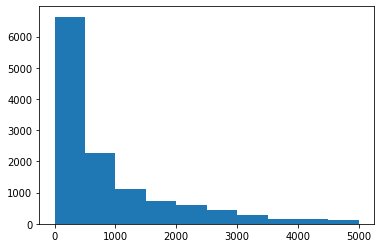

In [33]:
plt.hist(ativos_v1_p.query('limite_disponivel > 0 & limite_disponivel < 5000')
            .query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52').query('opens == 1')['limite_disponivel'])

(array([102235.,  31308.,  16352.,  10741.,   7775.,   5525.,   3458.,
          2378.,   1807.,   1441.]),
 array([1.000000e-02, 5.000020e+02, 9.999940e+02, 1.499986e+03,
        1.999978e+03, 2.499970e+03, 2.999962e+03, 3.499954e+03,
        3.999946e+03, 4.499938e+03, 4.999930e+03]),
 <BarContainer object of 10 artists>)

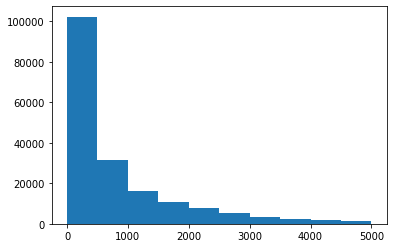

In [34]:
plt.hist(ativos_v1_p.query('limite_disponivel > 0 & limite_disponivel < 5000')
            .query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')['limite_disponivel'])

(array([4609., 2877., 1574., 1065.,  554.,  669.,  628.,  392.,  243.,
         207.]),
 array([ 100.,  580., 1060., 1540., 2020., 2500., 2980., 3460., 3940.,
        4420., 4900.]),
 <BarContainer object of 10 artists>)

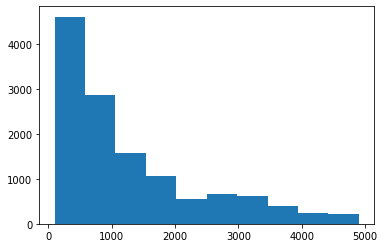

In [35]:
plt.hist(ativos_v1_p.query('limite > 0 & limite < 5000')
            .query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52').query('opens == 1')['limite'])

(array([64429., 42191., 25313., 16401., 13235., 11684.,  6629.,  5909.,
         3832.,  2617.]),
 array([ 100.,  589., 1078., 1567., 2056., 2545., 3034., 3523., 4012.,
        4501., 4990.]),
 <BarContainer object of 10 artists>)

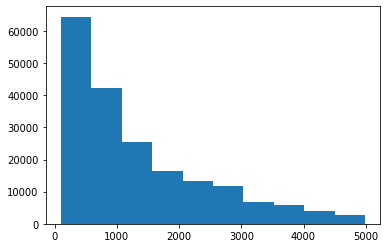

In [36]:
plt.hist(ativos_v1_p.query('limite > 0 & limite < 5000')
            .query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')['limite'])

(array([ 898., 1714., 1765., 1551., 1273., 1194., 1044.,  931.,  754.,
        1119.]),
 array([0.01 , 0.108, 0.206, 0.304, 0.402, 0.5  , 0.598, 0.696, 0.794,
        0.892, 0.99 ]),
 <BarContainer object of 10 artists>)

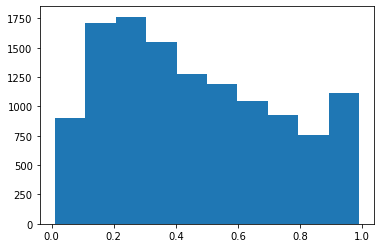

In [39]:
plt.hist(ativos_v1_p.query('iu > 0 & iu < 1')
            .query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52').query('opens == 1')['iu'])

(array([11195., 17105., 18923., 19604., 16922., 19044., 18417., 16908.,
        15138., 22414.]),
 array([0.01 , 0.108, 0.206, 0.304, 0.402, 0.5  , 0.598, 0.696, 0.794,
        0.892, 0.99 ]),
 <BarContainer object of 10 artists>)

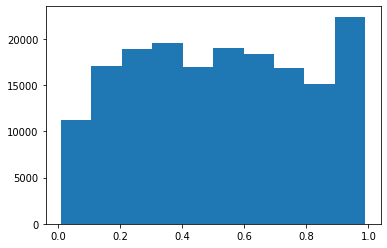

In [40]:
plt.hist(ativos_v1_p.query('iu > 0 & iu < 1')
            .query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')['iu'])

In [45]:
ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52').query('opens == 1')[['limite', 'nr_score_ie', 'limite_disponivel', 'iu']].corr()

,limite,nr_score_ie,limite_disponivel,iu
limite,1.000000,-0.027356,0.903862,-0.183121
nr_score_ie,-0.027356,1.000000,-0.033513,0.032194
limite_disponivel,0.903862,-0.033513,1.000000,-0.390914
iu,-0.183121,0.032194,-0.390914,1.000000


In [53]:
ativos_v1_p['fx_iu'] = pd.qcut(ativos_v1_p['iu'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
for x in ativos_v1_p['fx_iu'].unique():
    temp_df = pd.DataFrame()
    print(f"=============Faixa de IU: {x}============")
    temp_df= ativos_v1_p.query('opens == 1').query('segmento_mcc_agg != "0 - OUTROS"')
    try:
        temp_df = temp_df[temp_df['fx_iu'] == x]
        fc.testes_iterativos(temp_df)
    except:
        pass

=============Faixa de IU: 1============
          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      11845  0.467961  314.688512  1744318.42   3.113116  17256.0
controle   1416  0.496469  327.813954   230453.21   3.307255   2325.0
_____________________
Lift da conversão: -5.74%
Estatística t do teste de diferença de proporções: -2.03
P-valor do teste de diferença de proporções: 0.042246
Conclusão:
A diferença de conversão é estatisticamente significativa
______________________________________________________________
Lift do spending: -4.0%
Estatística t do teste de spending: -1.2
P-valor do teste de spending: 0.230741
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -5.87%
Estatística t do teste de frequencia: -2.49
P-valor do teste de freque

In [54]:
ativos_v1_p['fx_limite'] = pd.qcut(ativos_v1_p['limite'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
for x in ativos_v1_p['fx_limite'].unique():
    temp_df = pd.DataFrame()
    print(f"=============Faixa de limite: {x}============")
    temp_df= ativos_v1_p.query('opens == 1').query('segmento_mcc_agg != "0 - OUTROS"')
    try:
        temp_df = temp_df[temp_df['fx_limite'] == x]
        fc.testes_iterativos(temp_df)
    except:
        pass

=============Faixa de limite: 2============
          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      28524  0.529309  175.455000  2649019.59   3.402172  51366.0
controle   3388  0.524498  178.064074   316419.86   3.452448   6135.0
_____________________
Lift da conversão: 0.92%
Estatística t do teste de diferença de proporções: 0.53
P-valor do teste de diferença de proporções: 0.595906
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -1.47%
Estatística t do teste de spending: -0.2
P-valor do teste de spending: 0.837879
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -1.46%
Estatística t do teste de frequencia: -0.2
P-valor do teste de frequencia: 0.844

In [100]:
ativos_v1_p['fx_limite'] = pd.qcut(ativos_v1_p['limite'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
for x in ativos_v1_p['fx_limite'].unique():
    temp_df = pd.DataFrame()
    print(f"=============Faixa de limite: {x}============")
    temp_df= ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"')
    try:
        temp_df = temp_df[temp_df['fx_limite'] == x]
        fc.testes_iterativos(temp_df)
    except:
        pass

=============Faixa de limite: 2============
          grupo converteu    spending             transacoes          
          count      mean        mean         sum       mean       sum
grupo                                                                 
alvo      97084  0.524319  170.329164  8670265.41   3.418698  174022.0
controle  10711  0.523200  175.177775   981696.25   3.493398   19577.0
_____________________
Lift da conversão: 0.21%
Estatística t do teste de diferença de proporções: 0.22
P-valor do teste de diferença de proporções: 0.825865
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -2.77%
Estatística t do teste de spending: -1.68
P-valor do teste de spending: 0.093599
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -2.14%
Estatística t do teste de frequencia: -1.23
P-valor do teste de frequencia

In [55]:
ativos_v1_p['fx_limite_disp'] = pd.qcut(ativos_v1_p['limite_disponivel'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
for x in ativos_v1_p['fx_limite_disp'].unique():
    temp_df = pd.DataFrame()
    print(f"=============Faixa de limite: {x}============")
    temp_df= ativos_v1_p.query('opens == 1').query('segmento_mcc_agg != "0 - OUTROS"')
    try:
        temp_df = temp_df[temp_df['fx_limite_disp'] == x]
        fc.testes_iterativos(temp_df)
    except:
        pass

=============Faixa de limite: 5============
          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      22431  0.611297  211.552256  2900804.54   3.582410  49122.0
controle   2618  0.603132  219.188271   346098.28   3.612413   5704.0
_____________________
Lift da conversão: 1.35%
Estatística t do teste de diferença de proporções: 0.81
P-valor do teste de diferença de proporções: 0.417573
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -3.48%
Estatística t do teste de spending: -0.68
P-valor do teste de spending: 0.499104
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -0.83%
Estatística t do teste de frequencia: 0.18
P-valor do teste de frequencia: 0.86

In [85]:

for x in ativos_v1_p['cluster_persona'].unique():
    temp_df = pd.DataFrame()
    print(f"=============Faixa de persona: {x}============")
    temp_df= ativos_v1_p.query('nr_score_ie > 51.2').query('segmento_mcc_agg != "0 - OUTROS"')
    try:
        temp_df = temp_df[temp_df['cluster_persona'] == x]
        fc.testes_iterativos(temp_df)
    except:
        pass

=============Faixa de persona: 26============
          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      16844  0.608882  349.839827  3587957.27   4.052360  41561.0
controle   1909  0.587218  346.870250   388841.55   3.892953   4364.0
_____________________
Lift da conversão: 3.69%
Estatística t do teste de diferença de proporções: 1.84
P-valor do teste de diferença de proporções: 0.066311
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 0.86%
Estatística t do teste de spending: 0.87
P-valor do teste de spending: 0.38387
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 4.09%
Estatística t do teste de frequencia: 2.11
P-valor do teste de frequencia: 0.0344

In [21]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')
                     .query('limite >1800 & limite <= 2500').query('opens == 1'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      18326  0.581251  383.558759  4085667.90   4.007416  42687.0
controle   2185  0.574828  405.339865   509106.87   4.021497   5051.0
_____________________
Lift da conversão: 1.12%
Estatística t do teste de diferença de proporções: 0.58
P-valor do teste de diferença de proporções: 0.565285
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -5.37%
Estatística t do teste de spending: -1.14
P-valor do teste de spending: 0.255667
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -0.35%
Estatística t do teste de frequencia: 0.22
P-valor do teste de frequencia: 0.827209
A diferença de frequência não é signifi

In [57]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"')
                     .query('limite >1800 & limite <= 2500'))

          grupo converteu    spending              transacoes          
          count      mean        mean          sum       mean       sum
grupo                                                                  
alvo      80638  0.583422  368.642900  17343173.89   3.940611  185390.0
controle   8836  0.574129  378.056509   1917880.67   3.841120   19486.0
_____________________
Lift da conversão: 1.62%
Estatística t do teste de diferença de proporções: 1.68
P-valor do teste de diferença de proporções: 0.092621
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -2.49%
Estatística t do teste de spending: -0.47
P-valor do teste de spending: 0.636399
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 2.59%
Estatística t do teste de frequencia: 2.4
P-valor do teste de frequencia: 0.016477
A diferença de frequência é est

In [22]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')
                     .query('limite >900 & limite <= 2500').query('opens == 1'))

          grupo converteu    spending             transacoes          
          count      mean        mean         sum       mean       sum
grupo                                                                 
alvo      54624  0.571837  316.018617  9871157.51   3.880298  121205.0
controle   6571  0.567341  324.589756  1210070.61   3.888412   14496.0
_____________________
Lift da conversão: 0.79%
Estatística t do teste de diferença de proporções: 0.7
P-valor do teste de diferença de proporções: 0.48665
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -2.64%
Estatística t do teste de spending: -0.83
P-valor do teste de spending: 0.404296
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -0.21%
Estatística t do teste de frequencia: 0.29
P-valor do teste de frequencia: 0.772058
A diferença de frequência não é sign

In [23]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1')
                     .query('limite_disponivel >708 & limite_disponivel <= 1835')
                     .query('opens == 1'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      34128  0.620048  392.298760  8301434.06   4.018950  85045.0
controle   4136  0.618956  405.255473  1037454.01   4.017188  10284.0
_____________________
Lift da conversão: 0.18%
Estatística t do teste de diferença de proporções: 0.14
P-valor do teste de diferença de proporções: 0.891267
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -3.2%
Estatística t do teste de spending: -1.14
P-valor do teste de spending: 0.256009
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 0.04%
Estatística t do teste de frequencia: 0.09
P-valor do teste de frequencia: 0.926373
A diferença de frequência não é significa

In [24]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1').query('iu >0.65 & iu <= 0.79')
                     .query('opens == 1'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      21613  0.639615  334.119215  4618864.03   4.030888  55723.0
controle   2731  0.632003  351.705545   607043.77   3.943221   6806.0
_____________________
Lift da conversão: 1.2%
Estatística t do teste de diferença de proporções: 0.78
P-valor do teste de diferença de proporções: 0.435235
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -5.0%
Estatística t do teste de spending: -0.96
P-valor do teste de spending: 0.338731
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 2.22%
Estatística t do teste de frequencia: 1.21
P-valor do teste de frequencia: 0.226952
A diferença de frequência não é significat

In [25]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg != "0 - OUTROS"').query('opens == 1').query('iu >0.32 & iu <= 0.79')
                     .query('opens == 1'))

          grupo converteu    spending              transacoes          
          count      mean        mean          sum       mean       sum
grupo                                                                  
alvo      77490  0.640250  335.507869  16645551.91   3.912382  194105.0
controle   9512  0.634672  338.259672   2042073.64   3.916515   23644.0
_____________________
Lift da conversão: 0.88%
Estatística t do teste de diferença de proporções: 1.07
P-valor do teste de diferença de proporções: 0.284867
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -0.81%
Estatística t do teste de spending: 0.03
P-valor do teste de spending: 0.979672
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -0.11%
Estatística t do teste de frequencia: 0.51
P-valor do teste de frequencia: 0.607001
A diferença de frequência não 

In [31]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg == "0 - OUTROS"').query('opens == 1'))

           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      164950  0.415017  320.625574  21949064.91   3.014710  206378.0
controle   17103  0.410279  301.513684   2115721.52   2.956249   20744.0
_____________________
Lift da conversão: 1.15%
Estatística t do teste de diferença de proporções: 1.2
P-valor do teste de diferença de proporções: 0.231248
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 6.34%
Estatística t do teste de spending: 2.68
P-valor do teste de spending: 0.007317
Conclusão:
A diferença de spending é estatisticamente significativa
______________________________________________________________
Lift da frequência: 1.98%
Estatística t do teste de frequencia: 1.93
P-valor do teste de frequencia: 0.05397
A diferença de f

In [32]:
fc.testes_iterativos(ativos_v1_p.query('segmento_mcc_agg == "0 - OUTROS"').query('nr_score_ie >47.35 & nr_score_ie <= 51.52').query('opens == 1'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo      13330  0.447712  281.658716  1680939.22   2.820878  16835.0
controle   1475  0.429831  262.231830   166254.98   2.736593   1735.0
_____________________
Lift da conversão: 4.16%
Estatística t do teste de diferença de proporções: 1.31
P-valor do teste de diferença de proporções: 0.189892
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 7.41%
Estatística t do teste de spending: 1.33
P-valor do teste de spending: 0.184095
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 3.08%
Estatística t do teste de frequencia: 1.4
P-valor do teste de frequencia: 0.162804
A diferença de frequência não é significati

In [33]:
#cria faixa de IE
ativos_v1_p['fx_ie'] = pd.qcut(ativos_v1_p['nr_score_ie'].rank(method='first'), q=3, precision=0, labels = ['baixo', 'medio', 'alto'])
ativos_v1_p['fx_ie'].value_counts()

baixo    514866
medio    514866
alto     514866
Name: fx_ie, dtype: int64

In [34]:
for x in ['baixo', 'medio', 'alto']:
    temp_df = pd.DataFrame()
    print(f"=============Faixa de IE: {x}============")
    temp_df= ativos_v1_p.query('opens == 1')
    temp_df = temp_df[temp_df['fx_ie'] == x]
    fc.testes_iterativos(temp_df)

=============Faixa de IE: baixo============
           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      112290  0.342666  309.644825  11914513.59   2.617964  100734.0
controle   11943  0.344386  307.402470   1264346.36   2.626793   10804.0
_____________________
Lift da conversão: -0.5%
Estatística t do teste de diferença de proporções: -0.38
P-valor do teste de diferença de proporções: 0.70663
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 0.73%
Estatística t do teste de spending: 0.06
P-valor do teste de spending: 0.95265
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: -0.34%
Estatística t do teste de frequencia: -0.38
P-valor do teste de fre

In [35]:
ativos_v1_c.segmento_mcc_agg.value_counts()

0 - OUTROS                     696962
4 - SAUDE                      238634
3 - SERVICOS DE ALIMENTACAO    200283
2 - LOJAS DE DEPARTAMENTO      195689
1 - SUPERMERCADO               112159
5 - LOJAS ESPECIALIZADAS       111674
Name: segmento_mcc_agg, dtype: int64

In [36]:
#por segmento MCC
for x in ['0 - OUTROS', '4 - SAUDE', '3 - SERVICOS DE ALIMENTACAO','2 - LOJAS DE DEPARTAMENTO','1 - SUPERMERCADO', '5 - LOJAS ESPECIALIZADAS']:
    temp_df = pd.DataFrame()
    print(f"=============Segmento MCC: {x}============")
    temp_df= ativos_v1_p.query('opens == 1')
    temp_df = temp_df[temp_df['segmento_mcc_agg'] == x]
    fc.testes_iterativos(temp_df)

=============Segmento MCC: 0 - OUTROS============
           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      164950  0.415017  320.625574  21949064.91   3.014710  206378.0
controle   17103  0.410279  301.513684   2115721.52   2.956249   20744.0
_____________________
Lift da conversão: 1.15%
Estatística t do teste de diferença de proporções: 1.2
P-valor do teste de diferença de proporções: 0.231248
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 6.34%
Estatística t do teste de spending: 2.68
P-valor do teste de spending: 0.007317
Conclusão:
A diferença de spending é estatisticamente significativa
______________________________________________________________
Lift da frequência: 1.98%
Estatística t do teste de frequencia: 1.93
P-valo